# MRI Lesion Segmentation (ISLES 2022)

**Goal.** Build an end-to-end pipeline to preprocess MRI scans and generate lesion segmentation predictions compatible with the ISLES 2022 challenge format.

**Dataset.** ISLES 2022 challenge data (MRI multi-modal scans).

**Highlights.**
- Data preprocessing and normalization for multi-modal MRI.
- Inference pipeline for segmentation masks and challenge-style submission.
- Reproducible experiment structure for future model iterations.



## Environment preparation

In [ ]:
import os, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

print("torch:", torch.__version__)
device = torch.device("cpu") 
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
import atlas
atlas.data_fetch()

In [ ]:
import getpass, subprocess
# Decrypt the data; prompt user for password
subprocess.call(['openssl', 'aes-256-cbc', '-md', 'sha256', 
                 '-d', '-a', '-in',
                 'ATLAS_R2.0_encrypted.tar.gz', '-out', 'ATLAS_R2.0.tar.gz',
                 '-pass', f'pass:{getpass.getpass("Enter password")}'])
 
subprocess.call(['tar', '-xzf', 'ATLAS_R2.0.tar.gz'])

We should now have a directory called `ATLAS_2` in the current working directory:

In [ ]:
import os
os.listdir('./')

In [ ]:
import os
os.listdir('ATLAS_2')[:30]

In [ ]:
import atlas
atlas.bidsify_indi_atlas('ATLAS_2/', 'data/')

In [147]:
import bidsio
bids_loader = bidsio.BIDSLoader(data_entities=[{'subject': '',
                                               'session': '',
                                               'suffix': 'T1w',
                                               'space': 'MNI152NLin2009aSym'}],
                                target_entities=[{'suffix': 'mask',
                                                'label': 'L',
                                                'desc': 'T1lesion'}],
                                data_derivatives_names=['ATLAS'],
                                target_derivatives_names=['ATLAS'],
                                batch_size=2,
                                root_dir='data/train/')

We'll examine a few properties of the loader. First, let's verify that we have the correct number of subjects:

In [ ]:
tmp = bids_loader.load_sample(0)
print(f'There are {len(bids_loader)} subjects in our dataset.')
print(f'Every sample loads {len(tmp)} images.')
print(f'Images have these dimensions: {bids_loader.data_shape}')
print(f'Every batch will load {bids_loader.batch_size} samples.')

In [ ]:
for data, target in bids_loader.load_batches():
    print(f'Our data has the shape {data.shape}')
    print(f'Our target has the shape {target.shape}')
    # Cast to library and transfer to desired device
    # Train model
    break

data batch shape: (2, 1, 197, 233, 189)
target batch shape: (2, 1, 197, 233, 189)
vol shape: (197, 233, 189) dtype: float32 min/max: 0.0 151.5961151123047
msk shape: (197, 233, 189) dtype: float32 unique (first 10): [0. 1.] num_unique: 2
msk positive voxels (msk>0): 112451


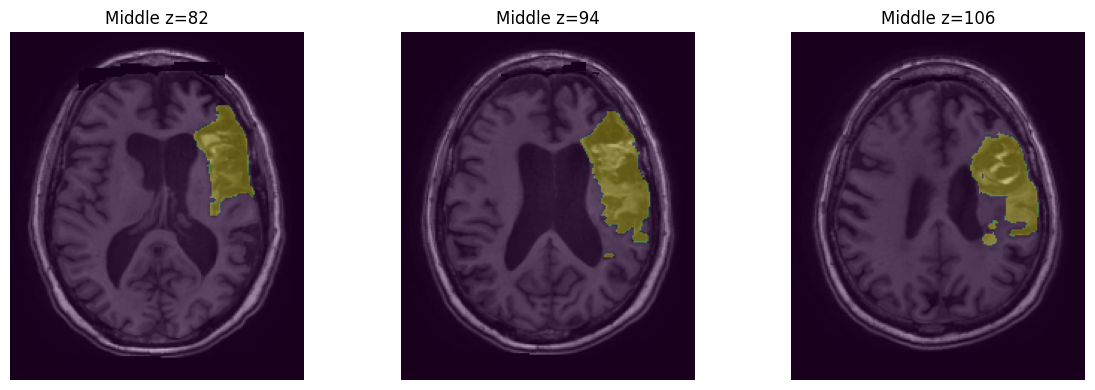

best lesion slice z: 95 positive voxels on that slice: 2396


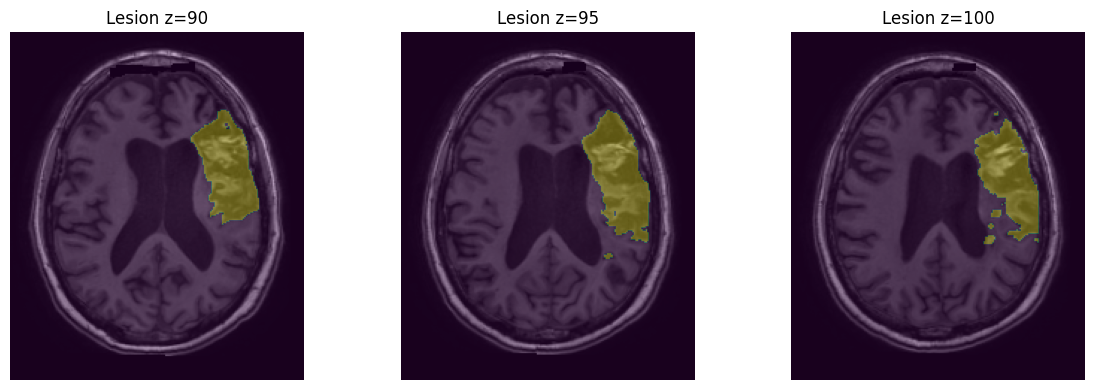

In [148]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# -----------------------
# Utilities
# -----------------------
def to_numpy(x):
    """Convert torch.Tensor or numpy-like to numpy ndarray."""
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def print_basic_stats(vol_np, msk_np):
    print("vol shape:", vol_np.shape, "dtype:", vol_np.dtype,
          "min/max:", float(np.min(vol_np)), float(np.max(vol_np)))
    uniq = np.unique(msk_np)
    print("msk shape:", msk_np.shape, "dtype:", msk_np.dtype,
          "unique (first 10):", uniq[:10], "num_unique:", len(uniq))
    pos = int(np.sum(msk_np > 0))
    print("msk positive voxels (msk>0):", pos)

def show_slices_overlay(vol_np, msk_np=None, zs=None, title_prefix=""):
    """
    vol_np: (H,W,D)
    msk_np: (H,W,D) or None
    zs: list of z indices to show
    """
    H, W, D = vol_np.shape
    if zs is None:
        mid = D // 2
        zs = [mid]

    fig, axes = plt.subplots(1, len(zs), figsize=(4 * len(zs), 4))
    if len(zs) == 1:
        axes = [axes]

    for ax, z in zip(axes, zs):
        z = int(np.clip(z, 0, D - 1))
        # transpose for more intuitive display; origin lower for medical-style view
        ax.imshow(vol_np[:, :, z].T, cmap="gray", origin="lower")
        if msk_np is not None:
            ax.imshow((msk_np[:, :, z] > 0).T, alpha=0.35, origin="lower")  # boolean overlay
        ax.set_title(f"{title_prefix} z={z}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

def find_best_lesion_slice(msk_np):
    """
    Return z index with the most positive voxels.
    msk_np: (H,W,D)
    """
    # count positives per slice along z
    z_counts = np.sum(msk_np > 0, axis=(0, 1))  # shape (D,)
    best_z = int(np.argmax(z_counts))
    return best_z, int(z_counts[best_z])

# -----------------------
# Main: inspect first batch
# -----------------------
for data, target in bids_loader.load_batches():
    print("data batch shape:", getattr(data, "shape", None))
    print("target batch shape:", getattr(target, "shape", None))

    # Take first sample in the batch, first channel
    vol = data[0, 0]
    msk = target[0, 0]

    vol_np = to_numpy(vol)
    msk_np = to_numpy(msk)

    # In case volume/mask are not exactly (H,W,D) (e.g., singleton dims),
    # squeeze safely:
    vol_np = np.squeeze(vol_np)
    msk_np = np.squeeze(msk_np)

    print_basic_stats(vol_np, msk_np)

    # 1) Show middle slice +/- offset
    D = vol_np.shape[-1]
    mid = D // 2
    offset = 12
    zs_mid = [max(0, mid - offset), mid, min(D - 1, mid + offset)]
    show_slices_overlay(vol_np, msk_np, zs=zs_mid, title_prefix="Middle")

    # 2) Show slices around the slice with the most lesion voxels
    best_z, best_count = find_best_lesion_slice(msk_np)
    print("best lesion slice z:", best_z, "positive voxels on that slice:", best_count)
    zs_best = [max(0, best_z - 5), best_z, min(D - 1, best_z + 5)]
    show_slices_overlay(vol_np, msk_np, zs=zs_best, title_prefix="Lesion")

    break

## Draw 40 samples

In [131]:
def collect_n_samples_from_loader(loader, n_samples=40):
    xs, ys = [], []
    for data, target in loader.load_batches():
        # 统一转 torch
        if not isinstance(data, torch.Tensor):
            data = torch.as_tensor(data)
        if not isinstance(target, torch.Tensor):
            target = torch.as_tensor(target)

        data = data.float()
        target = target.float()

        for i in range(data.shape[0]):
            xs.append(data[i])    # (1,H,W,D)
            ys.append(target[i])  # (1,H,W,D)
            if len(xs) >= n_samples:
                return xs, ys
    return xs, ys

X, Y = collect_n_samples_from_loader(bids_loader, n_samples=40)
print("collected:", len(X), "sample shape:", X[0].shape, Y[0].shape)

collected: 40 sample shape: torch.Size([1, 197, 233, 189]) torch.Size([1, 197, 233, 189])


## Training/validation partitioning + Patch sampling

In [132]:
idx = list(range(len(X)))
random.shuffle(idx)
split = int(0.8 * len(idx))
train_idx = idx[:split]
val_idx   = idx[split:]

X_tr = [X[i] for i in train_idx]; Y_tr = [Y[i] for i in train_idx]
X_va = [X[i] for i in val_idx];   Y_va = [Y[i] for i in val_idx]

print("train vols:", len(X_tr), "val vols:", len(X_va))

train vols: 32 val vols: 8


In [133]:
from torch.utils.data import Dataset
import random
import torch

class RandomPatchDataset3D(Dataset):
    def __init__(self, X, Y, patch_size=(64,64,64), patches_per_volume=4,
                 positive_fraction=0.7, max_tries=10):
        """
        positive_fraction: 取正样本patch（含病灶）的概率，比如0.7表示70%强制含病灶
        max_tries: 每次强制取正样本时最多重采样次数
        """
        self.X = X
        self.Y = Y
        self.ph, self.pw, self.pd = patch_size
        self.index = []
        for i in range(len(X)):
            for _ in range(patches_per_volume):
                self.index.append(i)

        self.positive_fraction = positive_fraction
        self.max_tries = max_tries

    def __len__(self):
        return len(self.index)

    def _random_crop(self, x, y):
        # x,y: (1,H,W,D)
        _, H, W, D = x.shape
        ph, pw, pd = self.ph, self.pw, self.pd

        h0 = random.randint(0, max(0, H - ph))
        w0 = random.randint(0, max(0, W - pw))
        d0 = random.randint(0, max(0, D - pd))

        x_patch = x[:, h0:h0+ph, w0:w0+pw, d0:d0+pd]  # (1,ph,pw,pd)
        y_patch = y[:, h0:h0+ph, w0:w0+pw, d0:d0+pd]
        return x_patch, y_patch

    def __getitem__(self, idx):
        i = self.index[idx]
        x = self.X[i].float()  # (1,H,W,D)
        y = (self.Y[i] > 0).float()  # 强制二值化为 0/1

        # 简单归一化（强烈建议）
        x = (x - x.mean()) / (x.std() + 1e-6)

        want_positive = (random.random() < self.positive_fraction)

        x_patch, y_patch = None, None

        # lesion-aware sampling：如果want_positive，则尽量采到 y_patch.sum()>0
        for attempt in range(self.max_tries):
            x_patch, y_patch = self._random_crop(x, y)
            if (not want_positive) or (y_patch.sum() > 0):
                break

        # -> (C,D,H,W) for Conv3d
        x_patch = x_patch.permute(0, 3, 1, 2).contiguous()
        y_patch = y_patch.permute(0, 3, 1, 2).contiguous()
        return x_patch, y_patch

from torch.utils.data import DataLoader

train_ds = RandomPatchDataset3D(X_tr, Y_tr, patch_size=(64,64,64), patches_per_volume=8,
                                positive_fraction=0.7, max_tries=10)
val_ds   = RandomPatchDataset3D(X_va, Y_va, patch_size=(64,64,64), patches_per_volume=4,
                                positive_fraction=0.0, max_tries=1)  # 验证集不要强制正样本

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False)

print("train patches:", len(train_ds), "val patches:", len(val_ds))

train patches: 256 val patches: 32


##  Model：PyTorch 3D U-Net

In [134]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.InstanceNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.InstanceNorm3d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels=1, base=8, out_channels=1):  # base=8 更适合CPU
        super().__init__()
        self.enc1 = ConvBlock(in_channels, base)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = ConvBlock(base, base*2)
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = ConvBlock(base*2, base*4)
        self.pool3 = nn.MaxPool3d(2)

        self.bottleneck = ConvBlock(base*4, base*8)

        self.up3 = nn.ConvTranspose3d(base*8, base*4, 2, 2)
        self.dec3 = ConvBlock(base*8, base*4)
        self.up2 = nn.ConvTranspose3d(base*4, base*2, 2, 2)
        self.dec2 = ConvBlock(base*4, base*2)
        self.up1 = nn.ConvTranspose3d(base*2, base, 2, 2)
        self.dec1 = ConvBlock(base*2, base)

        self.out = nn.Conv3d(base, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)              # (B,base, D,H,W)
        e2 = self.enc2(self.pool1(e1)) # (B,2b,  D/2,H/2,W/2)
        e3 = self.enc3(self.pool2(e2)) # (B,4b,  D/4,H/4,W/4)
        b  = self.bottleneck(self.pool3(e3)) # (B,8b, D/8,H/8,W/8)

        d3 = self.up3(b)
        # 对齐尺寸（关键）
        if d3.shape[2:] != e3.shape[2:]:
            d3 = center_crop_to(d3, e3)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        if d2.shape[2:] != e2.shape[2:]:
            d2 = center_crop_to(d2, e2)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        if d1.shape[2:] != e1.shape[2:]:
            d1 = center_crop_to(d1, e1)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.out(d1)  # logits (B,1,D,H,W)

model = UNet3D(base=8).to(device)
print("model ok")

model ok


## Define Loss ：BCEWithLogits + Dice

In [135]:
import torch.nn as nn
import torch

pos_weight = torch.tensor([20.0], device=device)  # try 20; if still empty preds, try 50
bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

def dice_loss_from_logits(logits, target, eps=1e-6):
    prob = torch.sigmoid(logits)
    target = target.float()
    inter = (prob * target).sum(dim=(1,2,3,4))
    denom = prob.sum(dim=(1,2,3,4)) + target.sum(dim=(1,2,3,4))
    dice = (2*inter + eps) / (denom + eps)
    return 1 - dice.mean()

def loss_fn(logits, target):
    return 0.7 * bce(logits, target) + 0.3 * dice_loss_from_logits(logits, target)

@torch.no_grad()
def dice_score_from_logits(logits, target, thr=0.5, eps=1e-6):
    prob = torch.sigmoid(logits)
    pred = (prob > thr).float()
    inter = (pred * target).sum(dim=(1,2,3,4))
    denom = pred.sum(dim=(1,2,3,4)) + target.sum(dim=(1,2,3,4))
    dice = (2*inter + eps) / (denom + eps)
    return dice.mean().item()

In [136]:
import numpy as np

def dice_score_from_logits_batch(logits, target, thr=0.5, eps=1e-6):
    prob = torch.sigmoid(logits)
    pred = (prob > thr).float()
    inter = (pred * target).sum(dim=(2,3,4))
    denom = pred.sum(dim=(2,3,4)) + target.sum(dim=(2,3,4))
    dice = (2*inter + eps) / (denom + eps)  # (B,C)
    return dice.mean(dim=1)  # (B,)

def run_epoch(loader, train=True, thr_eval=0.5):
    model.train(train)
    total_loss, n = 0.0, 0

    dices_all = []
    dices_lesion = []
    lesion_count = 0
    lesion_pred_nonempty = 0

    for x, y in loader:
        x = x.to(device)  # (B,C,D,H,W)
        y = y.to(device)

        logits = model(x)
        loss = loss_fn(logits, y)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += float(loss.item())
        n += 1

        # metrics
        d_each = dice_score_from_logits_batch(logits, y, thr=thr_eval)  # (B,)
        dices_all.extend(d_each.detach().cpu().numpy().tolist())

        gt_vox = y.sum(dim=(1,2,3,4)).detach().cpu().numpy()
        pr_vox = (torch.sigmoid(logits) > thr_eval).float().sum(dim=(1,2,3,4)).detach().cpu().numpy()

        for i in range(len(gt_vox)):
            if gt_vox[i] > 0:
                lesion_count += 1
                dices_lesion.append(float(d_each[i].item()))
                if pr_vox[i] > 0:
                    lesion_pred_nonempty += 1

    avg_loss = total_loss / max(1, n)
    dice_all_mean = float(np.mean(dices_all)) if dices_all else 0.0
    dice_all_median = float(np.median(dices_all)) if dices_all else 0.0

    if lesion_count > 0:
        dice_lesion_mean = float(np.mean(dices_lesion))
        dice_lesion_median = float(np.median(dices_lesion))
        pred_ratio = lesion_pred_nonempty / lesion_count
    else:
        dice_lesion_mean = dice_lesion_median = pred_ratio = 0.0

    stats = {
        "loss": avg_loss,
        "dice_all_mean": dice_all_mean,
        "dice_all_median": dice_all_median,
        "dice_lesion_mean": dice_lesion_mean,
        "dice_lesion_median": dice_lesion_median,
        "lesion_pred_nonempty_ratio": pred_ratio,
        "lesion_count": lesion_count
    }
    return stats



In [137]:
x, y = next(iter(train_loader))
print("GT vox:", int(y.sum().item()))

GT vox: 259


In [139]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 20
for epoch in range(1, EPOCHS + 1):
    tr = run_epoch(train_loader, train=True,  thr_eval=0.3)  # 训练时用0.3更早看到pred不为空
    va = run_epoch(val_loader,   train=False, thr_eval=0.3)  

    print(
        f"Epoch {epoch:02d} | "
        f"train loss {tr['loss']:.4f} "
        f"train dice(all) {tr['dice_all_mean']:.3f} "
        f"| val loss {va['loss']:.4f} "
        f"val dice(all) {va['dice_all_mean']:.3f} "
        f"val dice(lesion) {va['dice_lesion_mean']:.3f} "
        f"(n={va['lesion_count']}, pred_nonempty={va['lesion_pred_nonempty_ratio']:.2f})"
    )

Epoch 01 | train loss 0.7143 train dice(all) 0.051 | val loss 0.6086 val dice(all) 0.032 val dice(lesion) 0.087 (n=12, pred_nonempty=1.00)
Epoch 02 | train loss 0.6230 train dice(all) 0.042 | val loss 0.6298 val dice(all) 0.034 val dice(lesion) 0.120 (n=9, pred_nonempty=1.00)
Epoch 03 | train loss 0.6630 train dice(all) 0.048 | val loss 0.5839 val dice(all) 0.033 val dice(lesion) 0.088 (n=12, pred_nonempty=1.00)
Epoch 04 | train loss 0.6430 train dice(all) 0.045 | val loss 0.4902 val dice(all) 0.018 val dice(lesion) 0.065 (n=9, pred_nonempty=1.00)
Epoch 05 | train loss 0.6227 train dice(all) 0.056 | val loss 0.5326 val dice(all) 0.027 val dice(lesion) 0.094 (n=9, pred_nonempty=1.00)
Epoch 06 | train loss 0.6549 train dice(all) 0.065 | val loss 0.4922 val dice(all) 0.012 val dice(lesion) 0.056 (n=7, pred_nonempty=1.00)
Epoch 07 | train loss 0.6078 train dice(all) 0.061 | val loss 0.4615 val dice(all) 0.016 val dice(lesion) 0.047 (n=11, pred_nonempty=1.00)
Epoch 08 | train loss 0.6205 tr

In [140]:
#Save model
import os, torch
os.makedirs("checkpoints", exist_ok=True)

# 保存当前模型参数
torch.save(model.state_dict(), "checkpoints/model_current.pt")
print("saved to checkpoints/model_current.pt")

saved to checkpoints/model_current.pt


In [141]:
import os

os.makedirs("checkpoints", exist_ok=True)

log_text = """Epoch 01 | train loss 0.7143 train dice(all) 0.051 | val loss 0.6086 val dice(all) 0.032 val dice(lesion) 0.087 (n=12, pred_nonempty=1.00)
Epoch 02 | train loss 0.6230 train dice(all) 0.042 | val loss 0.6298 val dice(all) 0.034 val dice(lesion) 0.120 (n=9, pred_nonempty=1.00)
Epoch 03 | train loss 0.6630 train dice(all) 0.048 | val loss 0.5839 val dice(all) 0.033 val dice(lesion) 0.088 (n=12, pred_nonempty=1.00)
Epoch 04 | train loss 0.6430 train dice(all) 0.045 | val loss 0.4902 val dice(all) 0.018 val dice(lesion) 0.065 (n=9, pred_nonempty=1.00)
Epoch 05 | train loss 0.6227 train dice(all) 0.056 | val loss 0.5326 val dice(all) 0.027 val dice(lesion) 0.094 (n=9, pred_nonempty=1.00)
Epoch 06 | train loss 0.6549 train dice(all) 0.065 | val loss 0.4922 val dice(all) 0.012 val dice(lesion) 0.056 (n=7, pred_nonempty=1.00)
Epoch 07 | train loss 0.6078 train dice(all) 0.061 | val loss 0.4615 val dice(all) 0.016 val dice(lesion) 0.047 (n=11, pred_nonempty=1.00)
Epoch 08 | train loss 0.6205 train dice(all) 0.059 | val loss 0.5171 val dice(all) 0.052 val dice(lesion) 0.128 (n=13, pred_nonempty=1.00)
Epoch 09 | train loss 0.6539 train dice(all) 0.070 | val loss 0.4831 val dice(all) 0.020 val dice(lesion) 0.063 (n=10, pred_nonempty=1.00)
Epoch 10 | train loss 0.5950 train dice(all) 0.068 | val loss 0.4439 val dice(all) 0.010 val dice(lesion) 0.033 (n=10, pred_nonempty=1.00)
Epoch 11 | train loss 0.5989 train dice(all) 0.062 | val loss 0.6104 val dice(all) 0.054 val dice(lesion) 0.156 (n=11, pred_nonempty=1.00)
Epoch 12 | train loss 0.5873 train dice(all) 0.068 | val loss 0.5469 val dice(all) 0.047 val dice(lesion) 0.214 (n=7, pred_nonempty=1.00)
Epoch 13 | train loss 0.6180 train dice(all) 0.066 | val loss 0.4305 val dice(all) 0.023 val dice(lesion) 0.120 (n=6, pred_nonempty=1.00)
Epoch 14 | train loss 0.6141 train dice(all) 0.060 | val loss 0.5121 val dice(all) 0.030 val dice(lesion) 0.105 (n=9, pred_nonempty=1.00)
Epoch 15 | train loss 0.5993 train dice(all) 0.056 | val loss 0.4329 val dice(all) 0.020 val dice(lesion) 0.054 (n=12, pred_nonempty=1.00)
Epoch 16 | train loss 0.6122 train dice(all) 0.064 | val loss 0.4793 val dice(all) 0.027 val dice(lesion) 0.073 (n=12, pred_nonempty=1.00)
Epoch 17 | train loss 0.5627 train dice(all) 0.069 | val loss 0.4243 val dice(all) 0.012 val dice(lesion) 0.034 (n=11, pred_nonempty=1.00)
Epoch 18 | train loss 0.5671 train dice(all) 0.065 | val loss 0.4881 val dice(all) 0.029 val dice(lesion) 0.083 (n=11, pred_nonempty=1.00)
Epoch 19 | train loss 0.5542 train dice(all) 0.072 | val loss 0.4487 val dice(all) 0.043 val dice(lesion) 0.124 (n=11, pred_nonempty=1.00)
Epoch 20 | train loss 0.6102 train dice(all) 0.071 | val loss 0.5398 val dice(all) 0.037 val dice(lesion) 0.108 (n=11, pred_nonempty=1.00)
"""

path = "checkpoints/train_log.txt"
with open(path, "w", encoding="utf-8") as f:
    f.write(log_text)

print("saved:", path)
print("checkpoints dir:", os.listdir("checkpoints"))

saved: checkpoints/train_log.txt
checkpoints dir: ['topk_nonempty', 'seg_debug_patch.png', 'training_log.txt', 'unet3d_baseline_epoch3.pth', 'model_current.pt', 'gt_vs_pred_patch.png', 'topk', 'train_log.txt', 'diverse', 'seg_zoomed.png', 'diverse3']


In [144]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# ---- settings ----
thr = 0.3
topk = 6
out_dir = "checkpoints/vis_topk"
os.makedirs(out_dir, exist_ok=True)

# ---- load model (你已经保存了 model_current.pt) ----
ckpt_path = "checkpoints/model_current.pt"
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()
print("loaded:", ckpt_path)

def dice_single(pred, gt, eps=1e-6):
    inter = (pred * gt).sum()
    denom = pred.sum() + gt.sum()
    return float((2*inter + eps) / (denom + eps))

def pick_best_slice(gt_3d):
    return int(np.argmax(gt_3d.sum(axis=(1,2))))

def save_comparison(x_3d, gt_3d, pr_3d, out_path, title=""):
    z0 = pick_best_slice(gt_3d)

    # 先生成候选
    zs = [z0-1, z0, z0+1]
    zs = [z for z in zs if 0 <= z < gt_3d.shape[0]]          # 去掉越界
    zs = sorted(list(dict.fromkeys(zs)))                      # 去重并保持顺序

    # 如果因为边界去重后不足3个，就补齐
    while len(zs) < 3:
        # 往另一侧再补一层
        cand = zs[0] - 1 if zs[0] > 0 else zs[-1] + 1
        if 0 <= cand < gt_3d.shape[0] and cand not in zs:
            zs.append(cand)
        else:
            break
    zs = sorted(zs)[:3]

    fig, axes = plt.subplots(len(zs), 4, figsize=(14, 10))
    if len(zs) == 1:
        axes = np.expand_dims(axes, axis=0)

    for r, z in enumerate(zs):
        img = x_3d[z]
        gt = gt_3d[z]
        pr = pr_3d[z]

        axes[r,0].imshow(img, cmap="gray"); axes[r,0].axis("off")
        axes[r,0].set_title(f"MRI (z={z})")

        axes[r,1].imshow(img, cmap="gray"); axes[r,1].axis("off")
        axes[r,1].imshow(gt, alpha=0.5, cmap="Reds", vmin=0, vmax=1)
        axes[r,1].set_title("GT mask")

        axes[r,2].imshow(img, cmap="gray"); axes[r,2].axis("off")
        axes[r,2].imshow(pr, alpha=0.5, cmap="Greens", vmin=0, vmax=1)
        axes[r,2].set_title(f"Pred (thr={thr})")

        axes[r,3].imshow(img, cmap="gray"); axes[r,3].axis("off")
        axes[r,3].imshow(gt, alpha=0.45, cmap="Reds", vmin=0, vmax=1)
        axes[r,3].imshow(pr, alpha=0.35, cmap="Greens", vmin=0, vmax=1)
        axes[r,3].set_title("Overlay")

    plt.suptitle(title, y=0.99)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close(fig)

# ---- scan val set, collect candidates ----
cands = []
with torch.no_grad():
    for k, (x, y) in enumerate(val_loader):
        x = x.to(device).float()  # (B,1,D,H,W)
        y = y.to(device).float()

        x_np = x[0,0].detach().cpu().numpy()                         # (D,H,W)
        gt_np = (y[0,0].detach().cpu().numpy() > 0).astype(np.uint8) # (D,H,W)

        if gt_np.sum() == 0:
            continue

        logits = model(x)
        prob = torch.sigmoid(logits)
        pred = (prob > thr).float()
        pr_np = (pred[0,0].detach().cpu().numpy() > 0).astype(np.uint8)

        d = dice_single(pr_np, gt_np)
        cands.append({
            "dice": d,
            "x": x_np,
            "gt": gt_np,
            "pr": pr_np,
            "idx": k,
            "gt_vox": int(gt_np.sum()),
            "pr_vox": int(pr_np.sum())
        })

print("GT non-empty candidates:", len(cands))
if len(cands) == 0:
    print("No lesion patches in this val scan. (Increase val patches_per_volume or rerun once.)")
else:
    cands.sort(key=lambda r: r["dice"], reverse=True)
    chosen = cands[:min(topk, len(cands))]

    for rank, r in enumerate(chosen, start=1):
        title = f"Top-{rank} | Dice={r['dice']:.3f} | GTvox={r['gt_vox']} Predvox={r['pr_vox']} | val_idx={r['idx']}"
        out_path = os.path.join(out_dir, f"top{rank}_dice{r['dice']:.3f}_gt{r['gt_vox']}_pr{r['pr_vox']}.png")
        save_comparison(r["x"], r["gt"], r["pr"], out_path, title=title)
        print("saved:", out_path)

    print("\nDone. Folder:", out_dir)

loaded: checkpoints/model_current.pt
GT non-empty candidates: 10
saved: checkpoints/vis_topk/top1_dice0.767_gt83412_pr66711.png
saved: checkpoints/vis_topk/top2_dice0.085_gt3414_pr54010.png
saved: checkpoints/vis_topk/top3_dice0.031_gt1197_pr43982.png
saved: checkpoints/vis_topk/top4_dice0.019_gt1905_pr36616.png
saved: checkpoints/vis_topk/top5_dice0.011_gt248_pr44085.png
saved: checkpoints/vis_topk/top6_dice0.003_gt98_pr47234.png

Done. Folder: checkpoints/vis_topk


checkpoints/vis_topk/top1_dice0.186_gt7052_pr54112.png


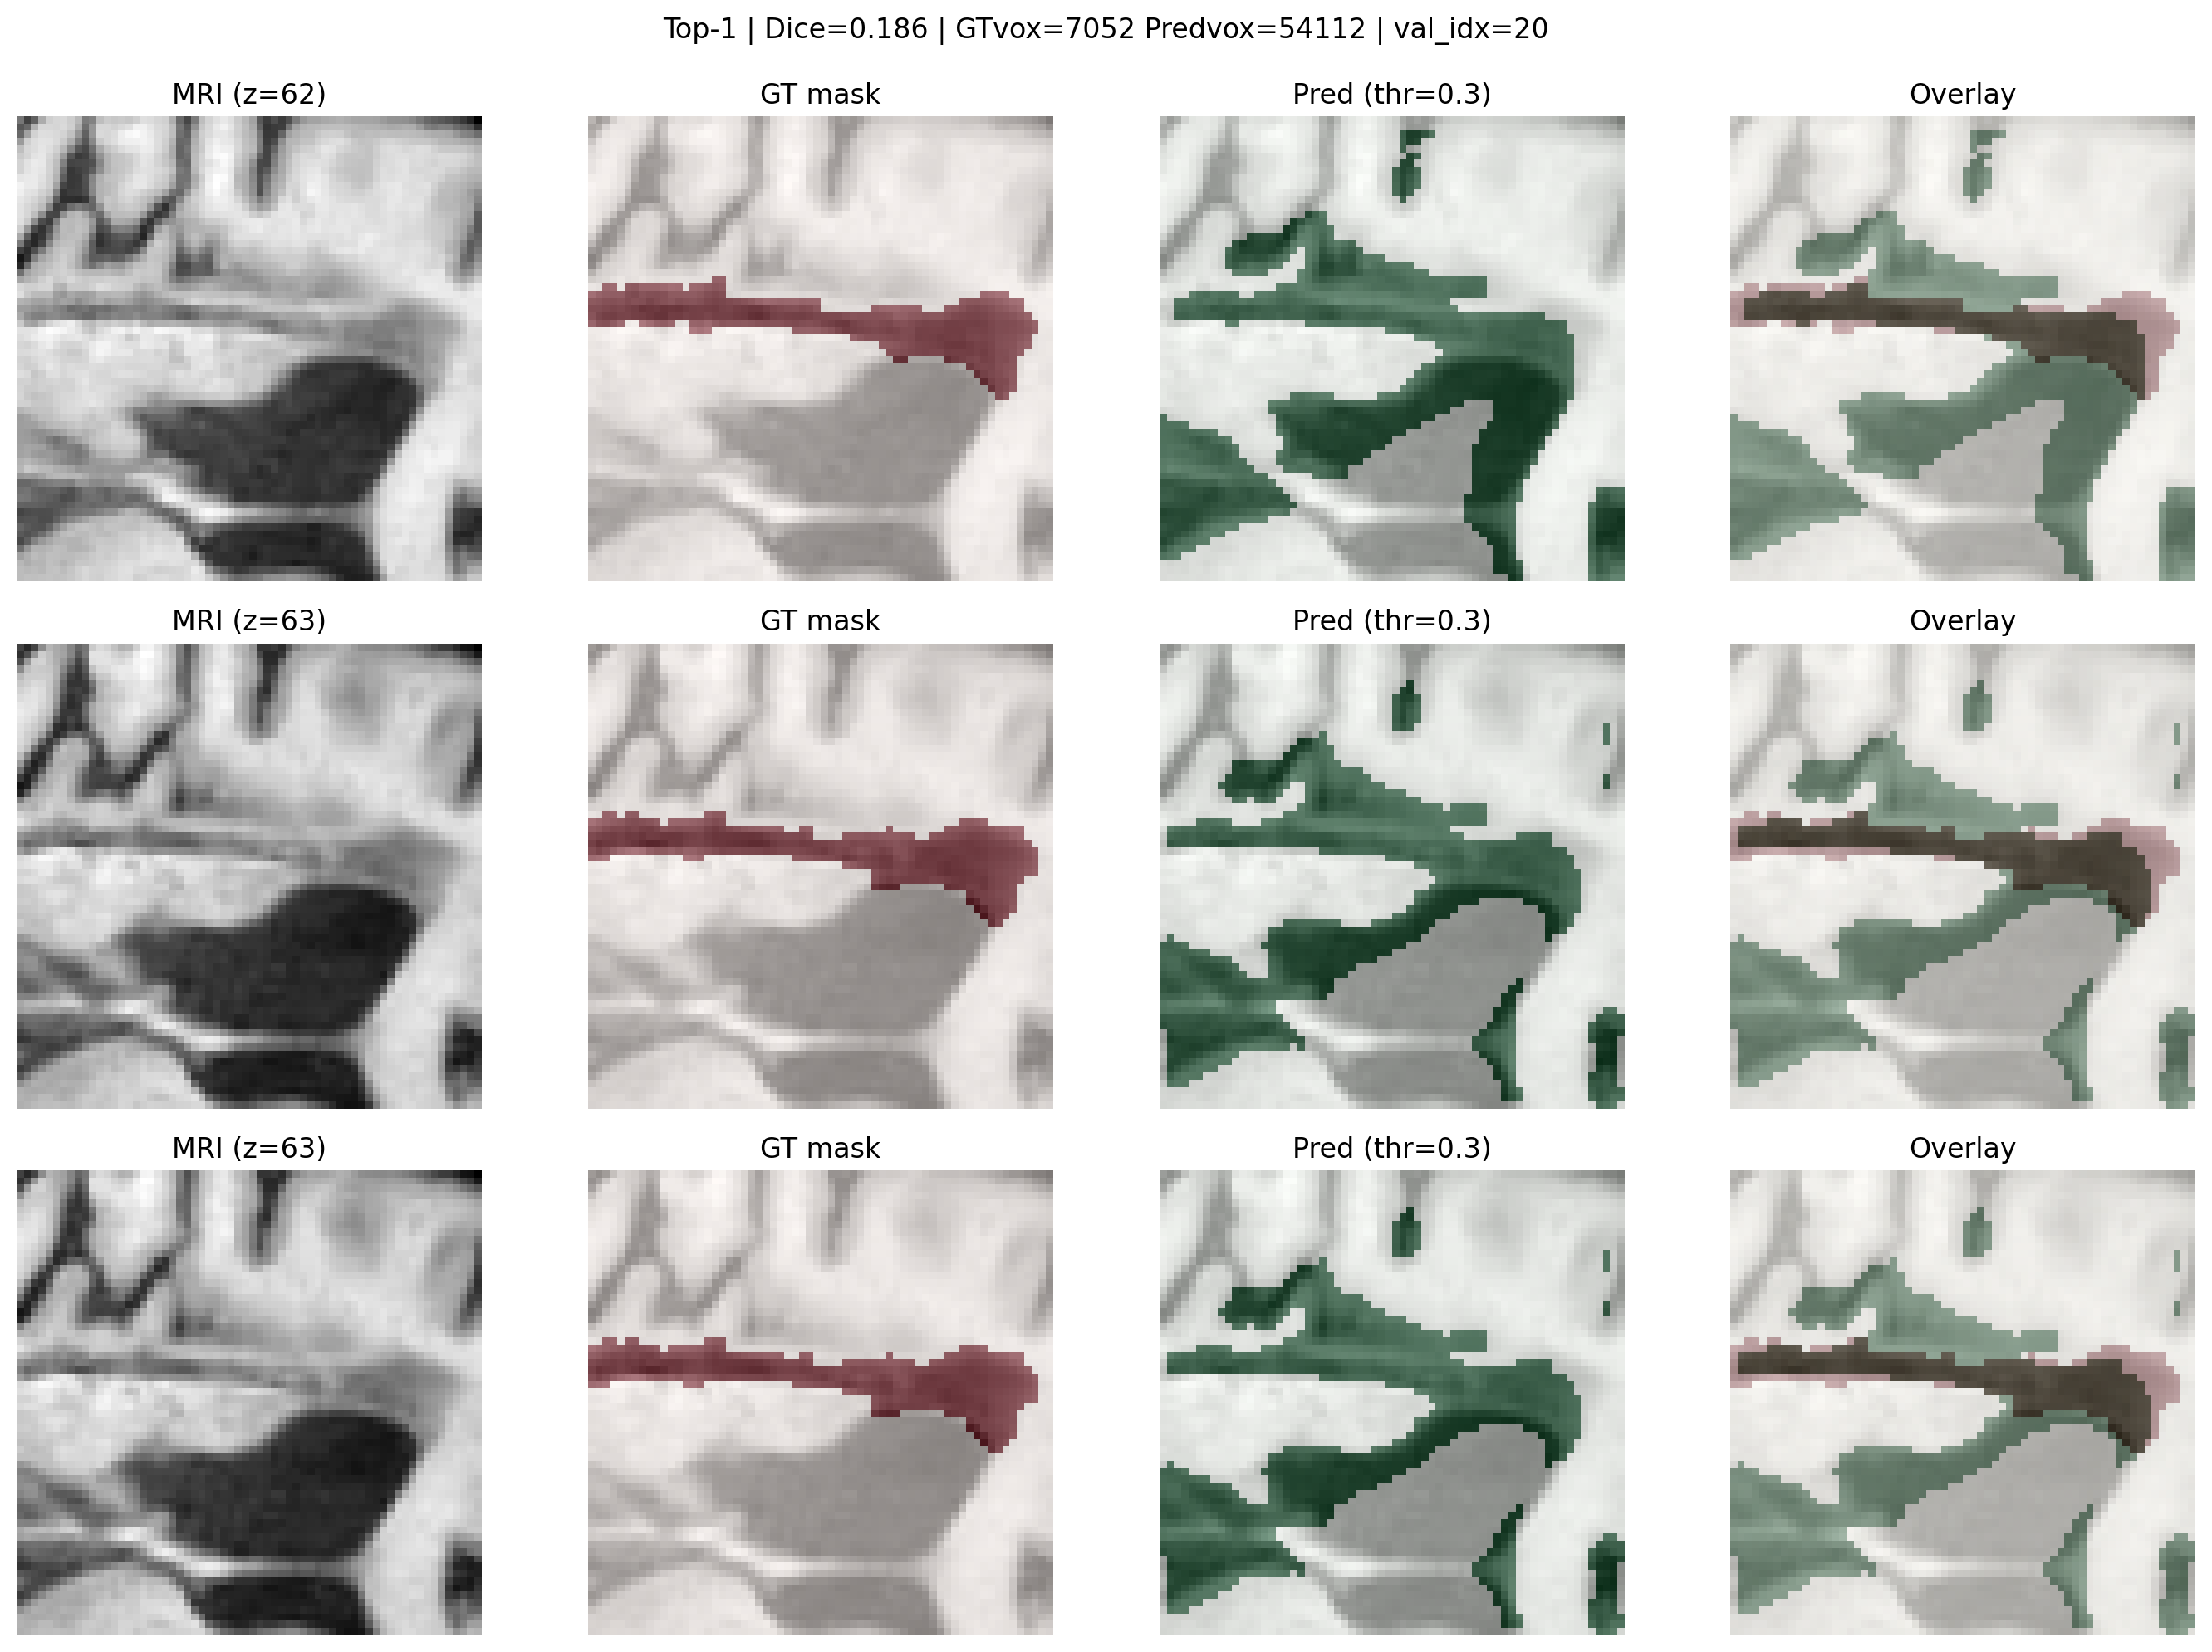

checkpoints/vis_topk/top1_dice0.767_gt83412_pr66711.png


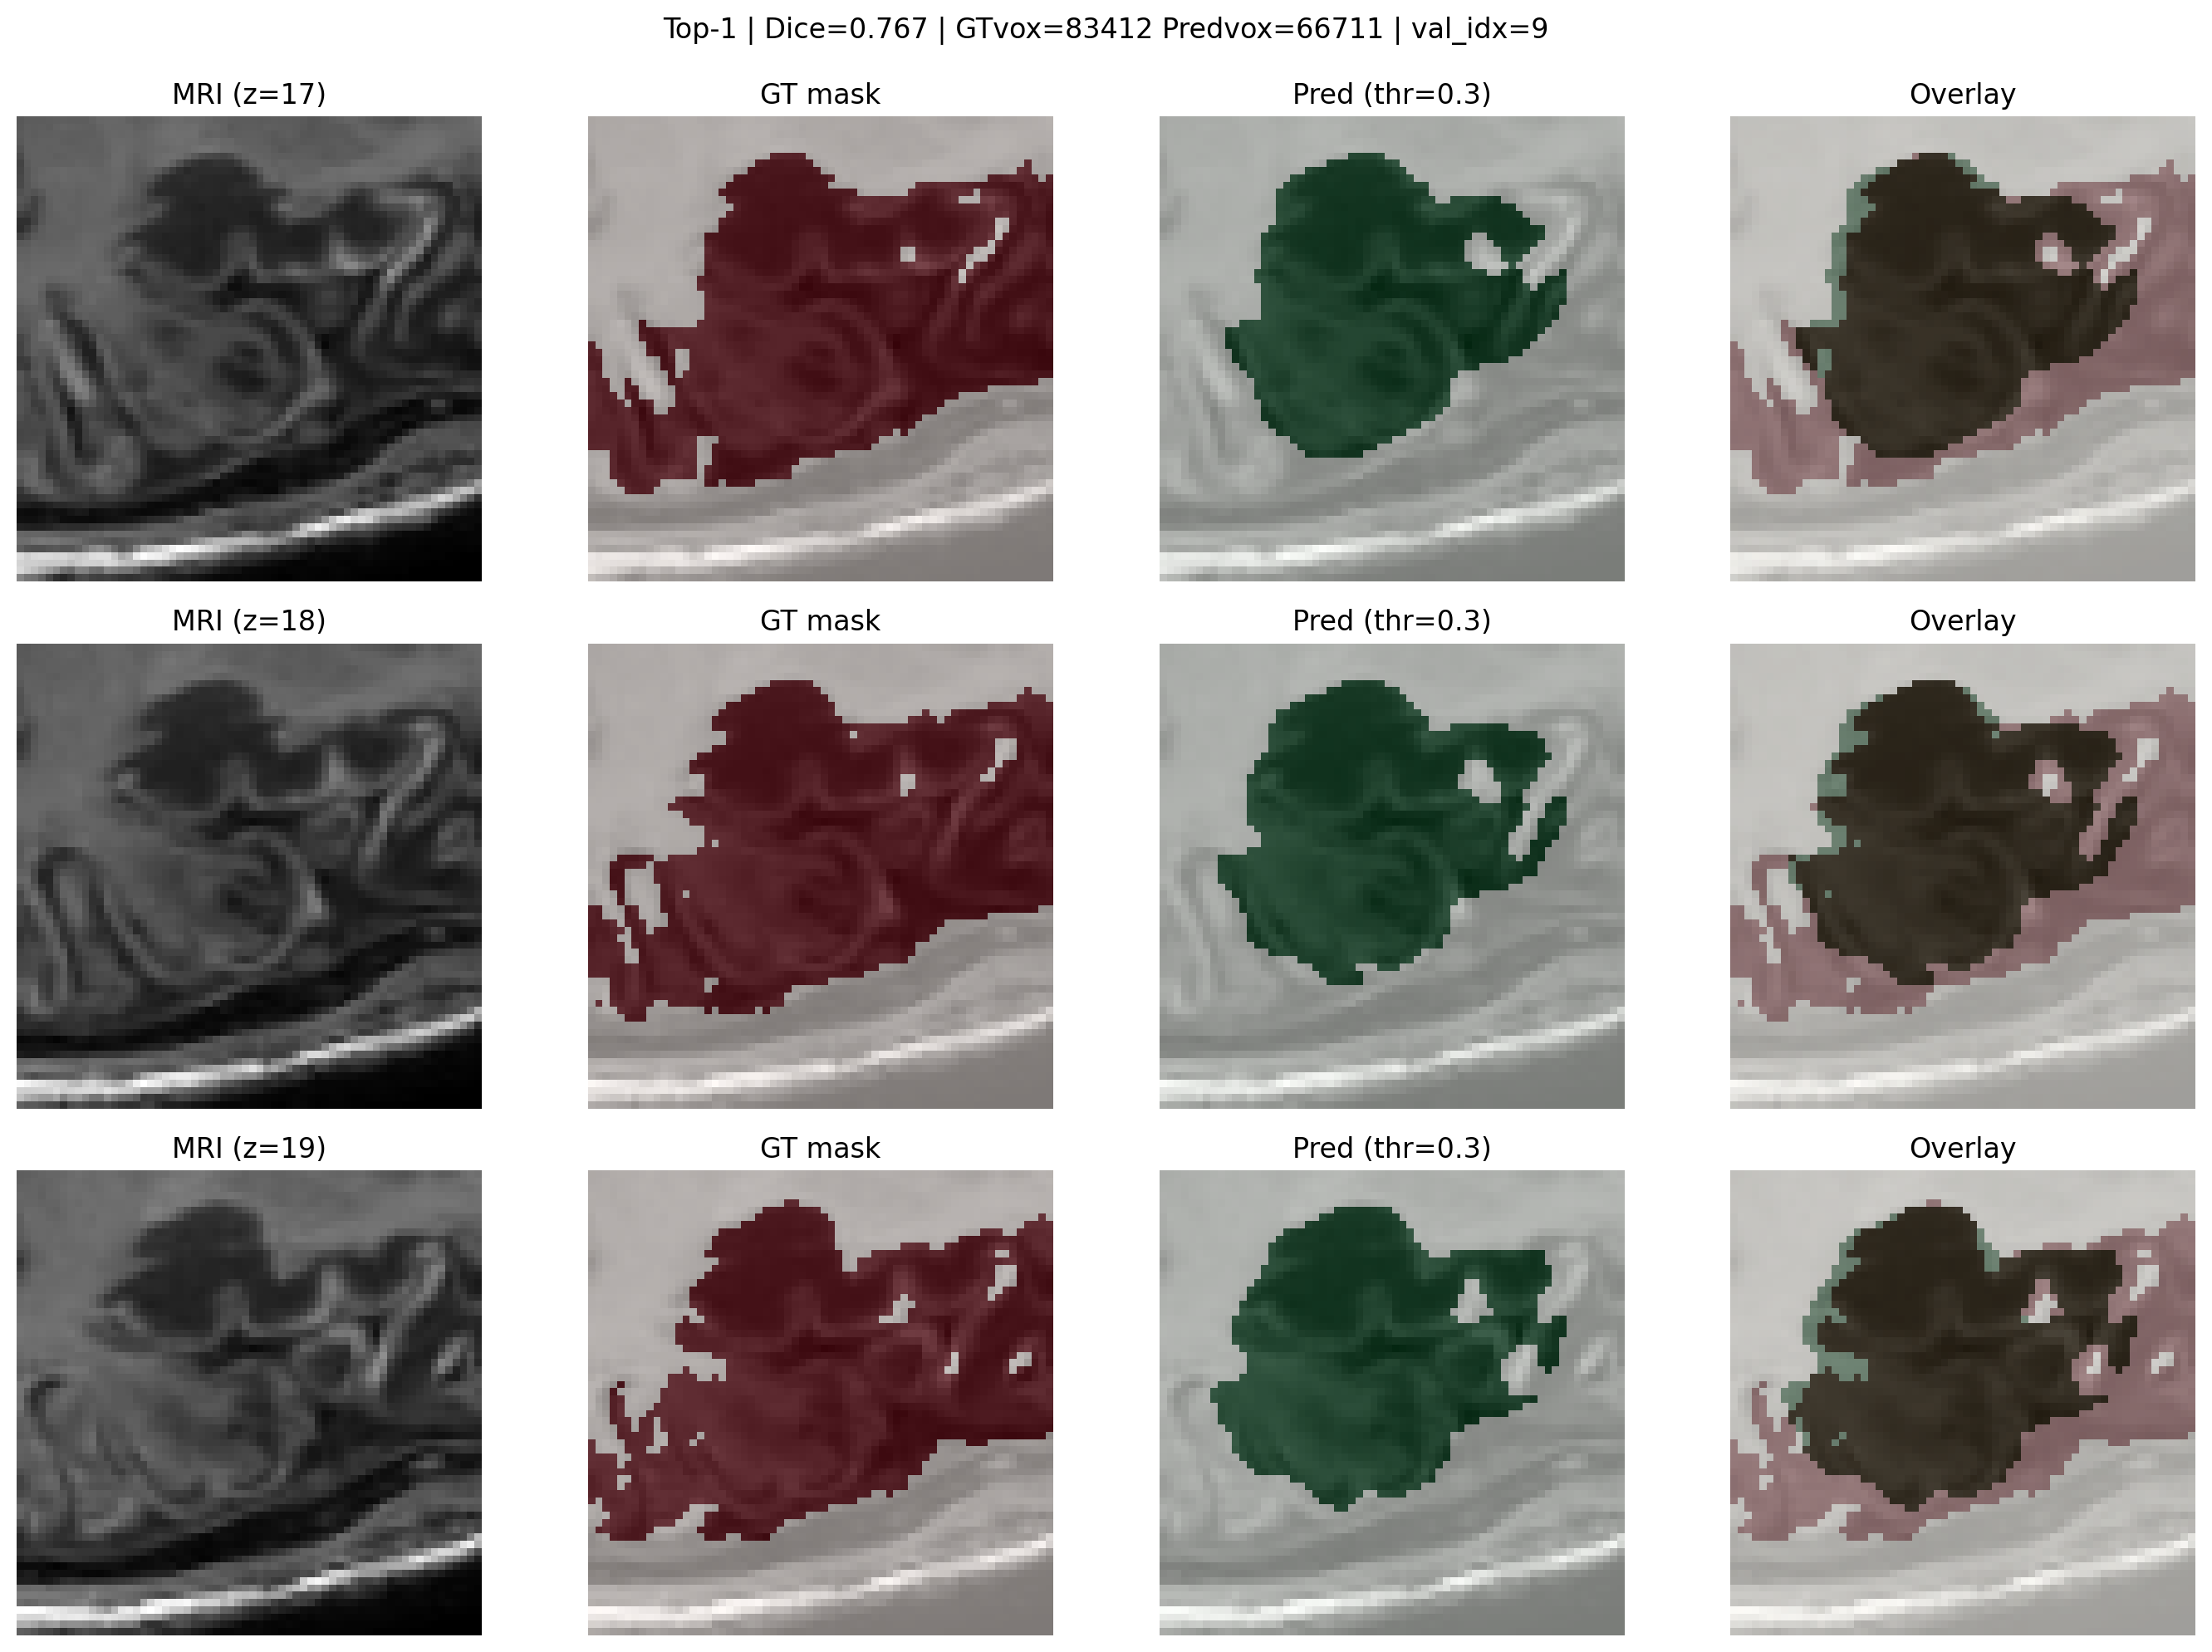

checkpoints/vis_topk/top2_dice0.085_gt3414_pr54010.png


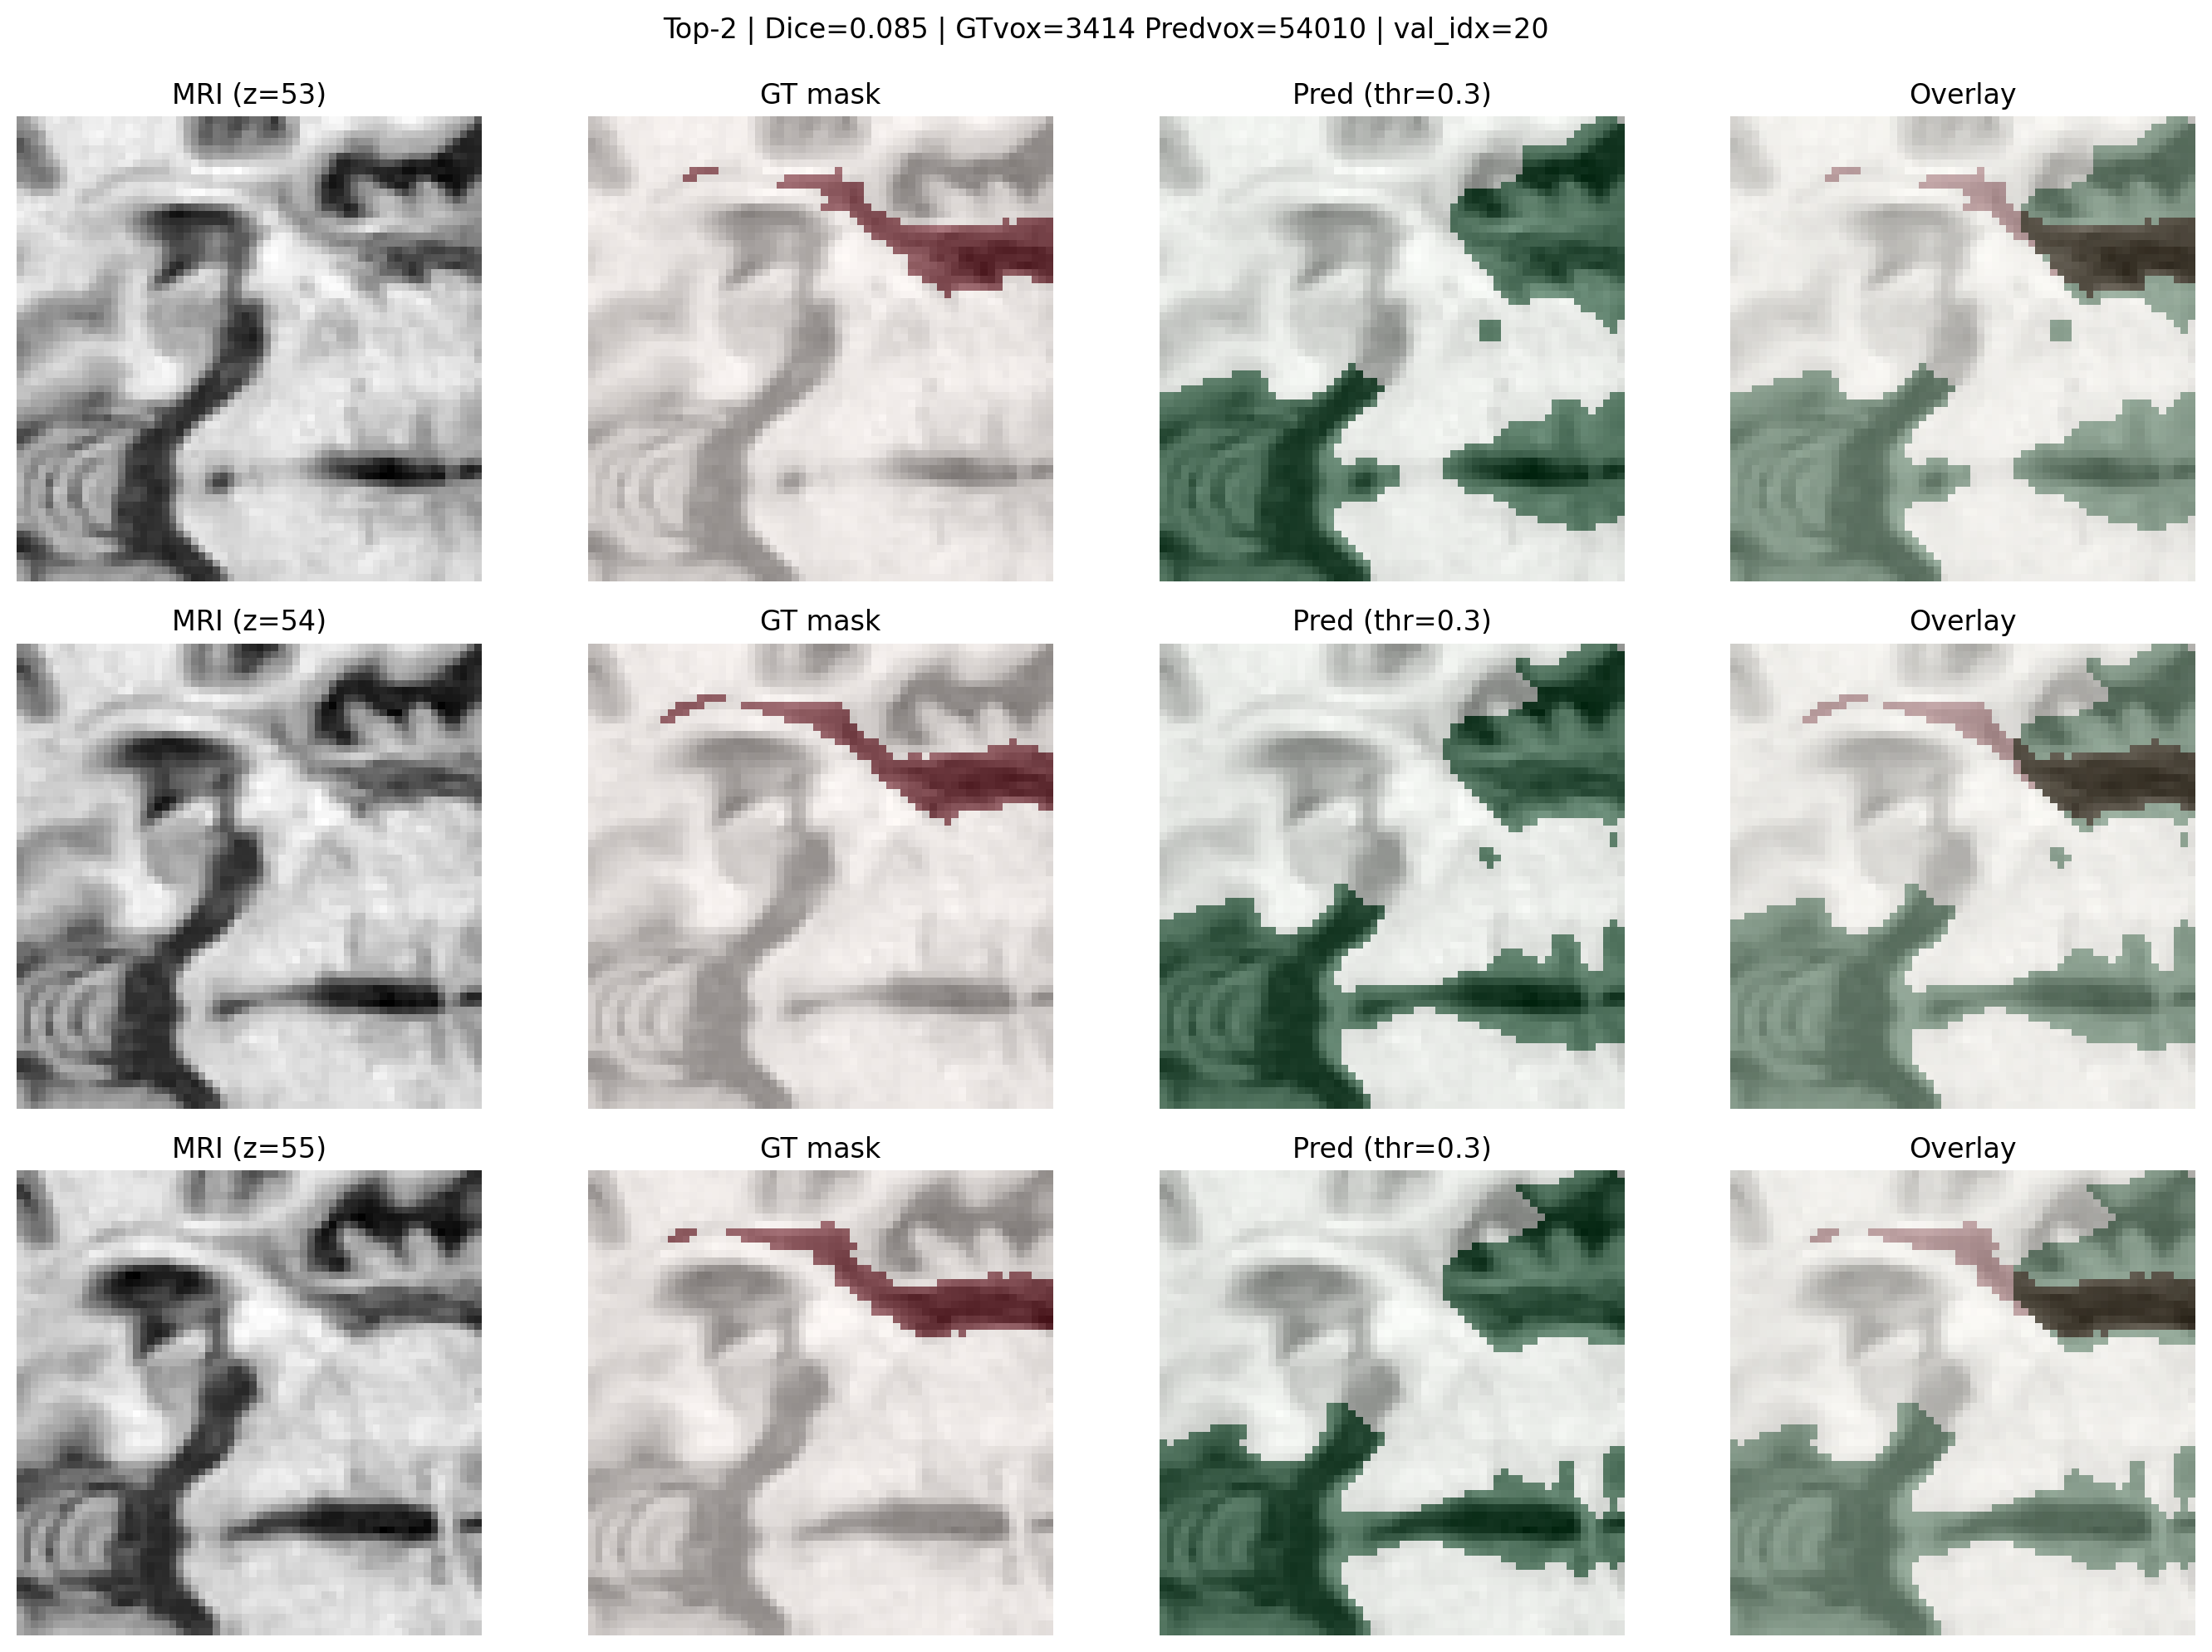

checkpoints/vis_topk/top2_dice0.171_gt5713_pr46870.png


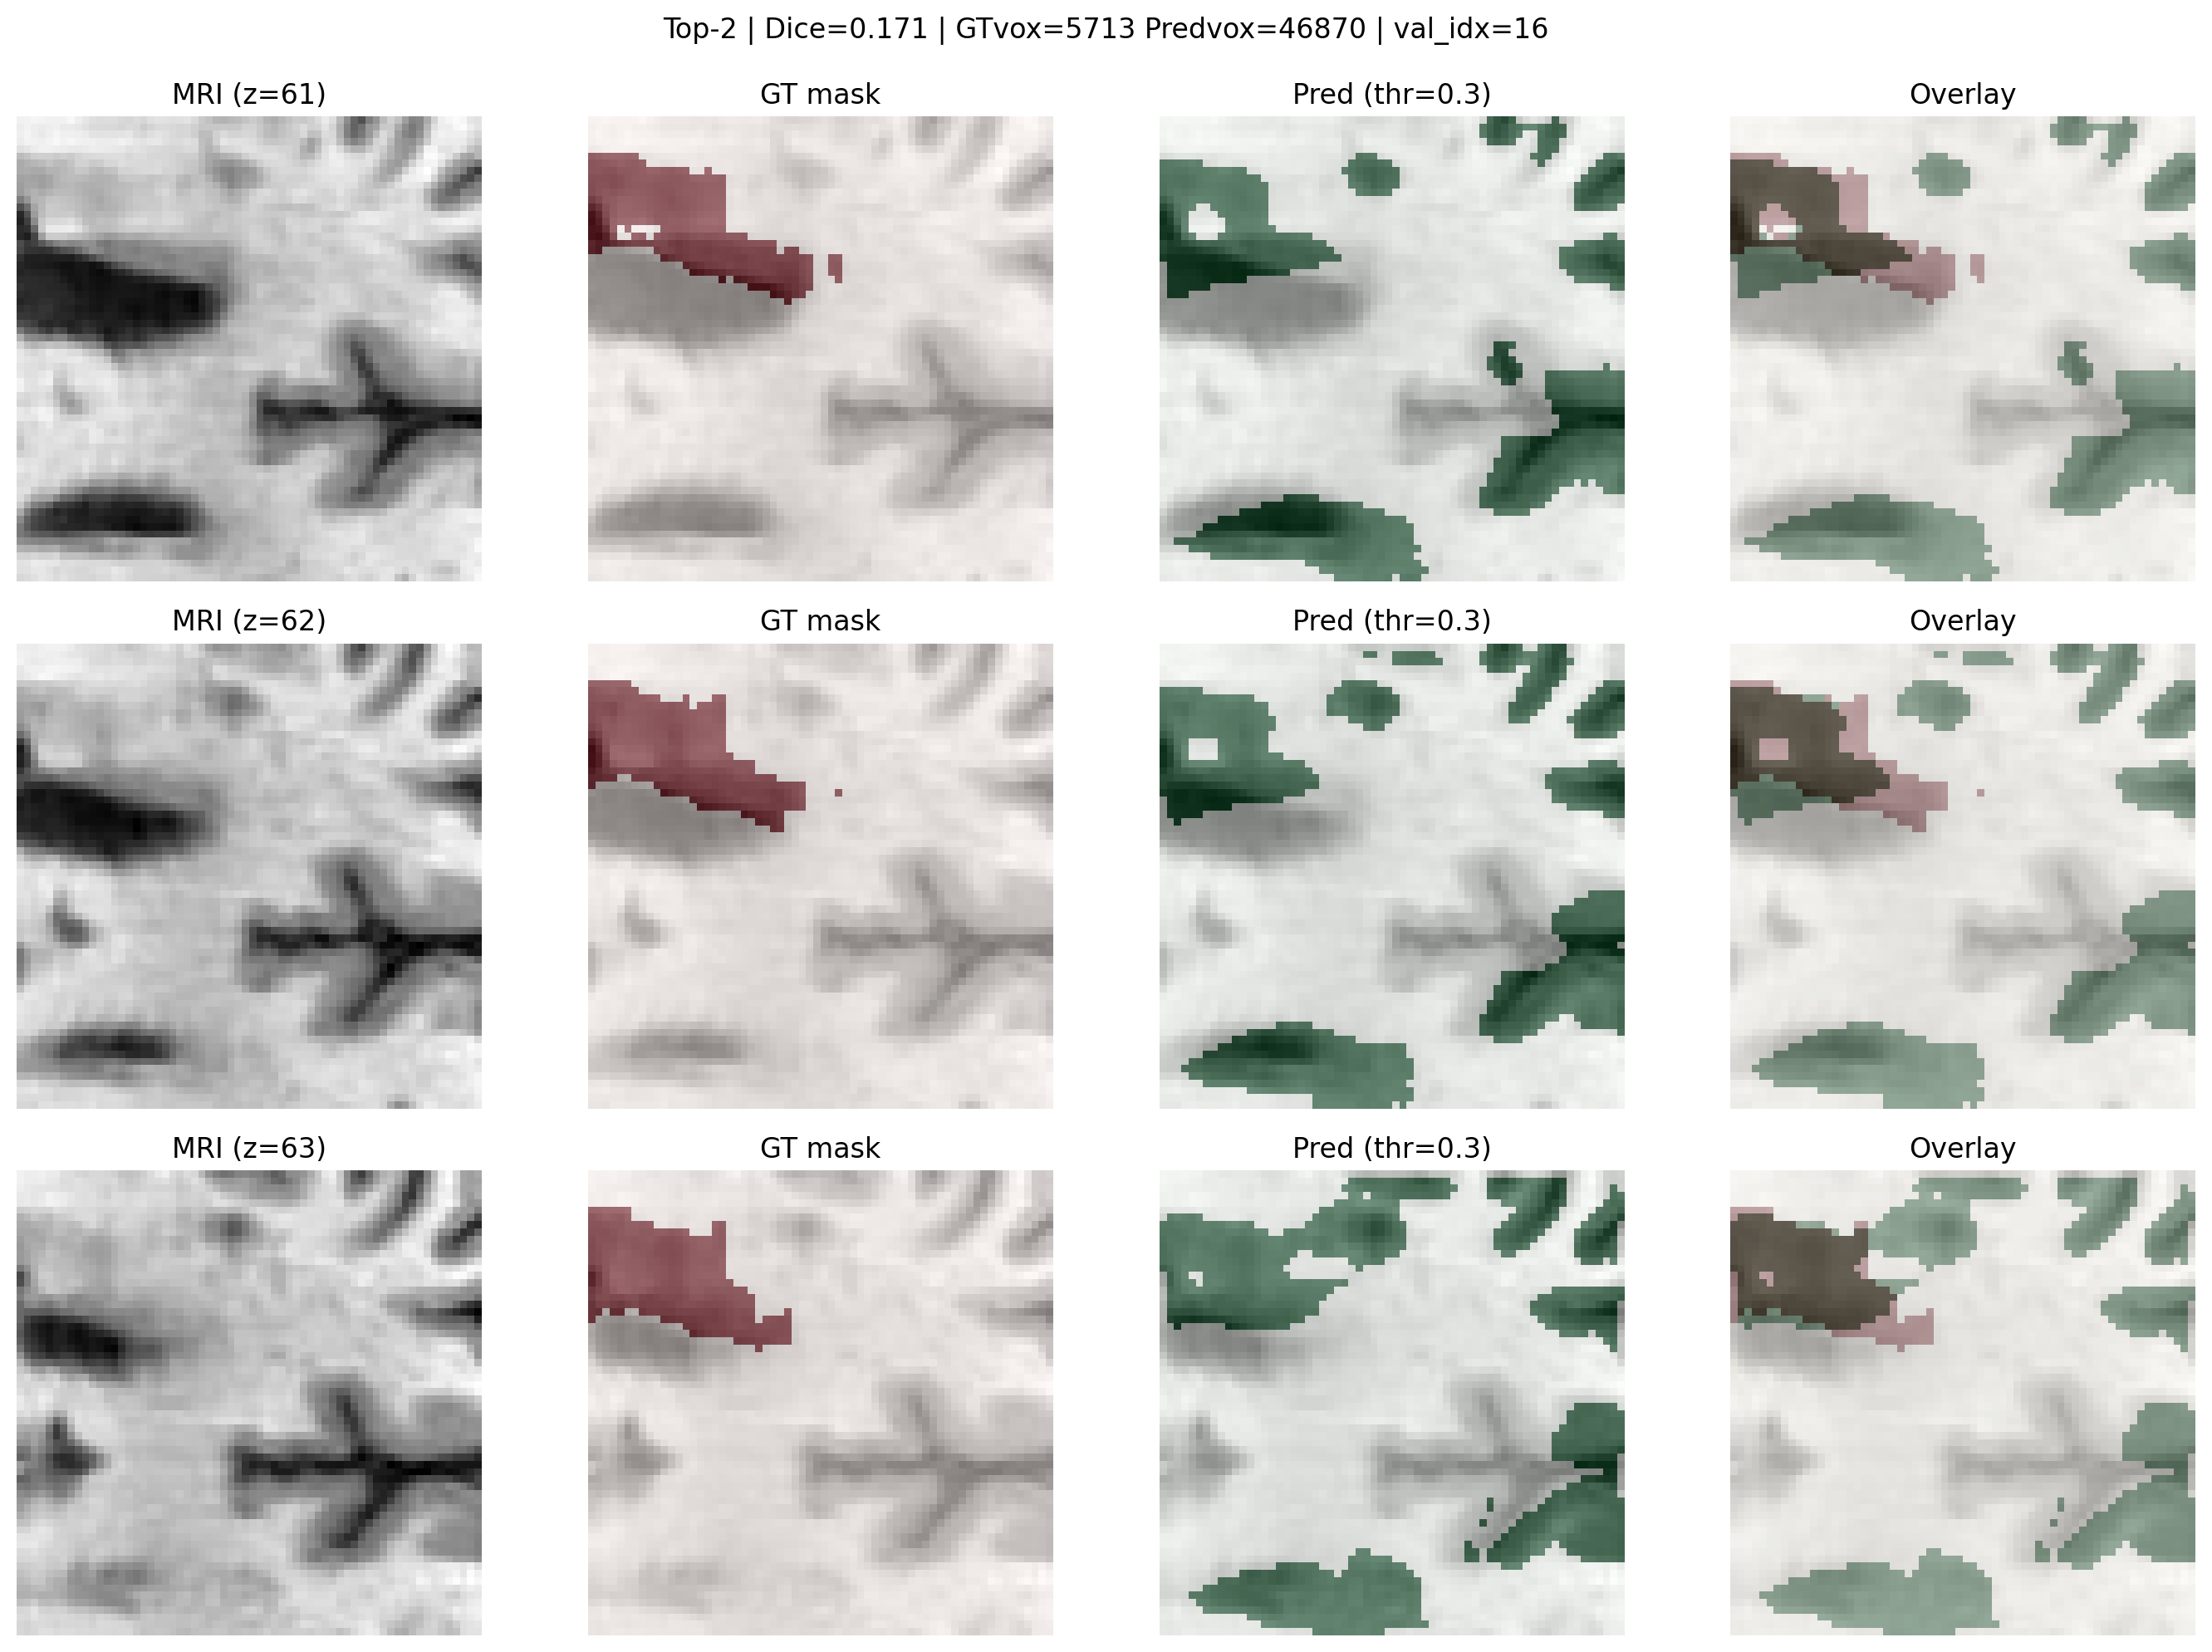

checkpoints/vis_topk/top3_dice0.031_gt1197_pr43982.png


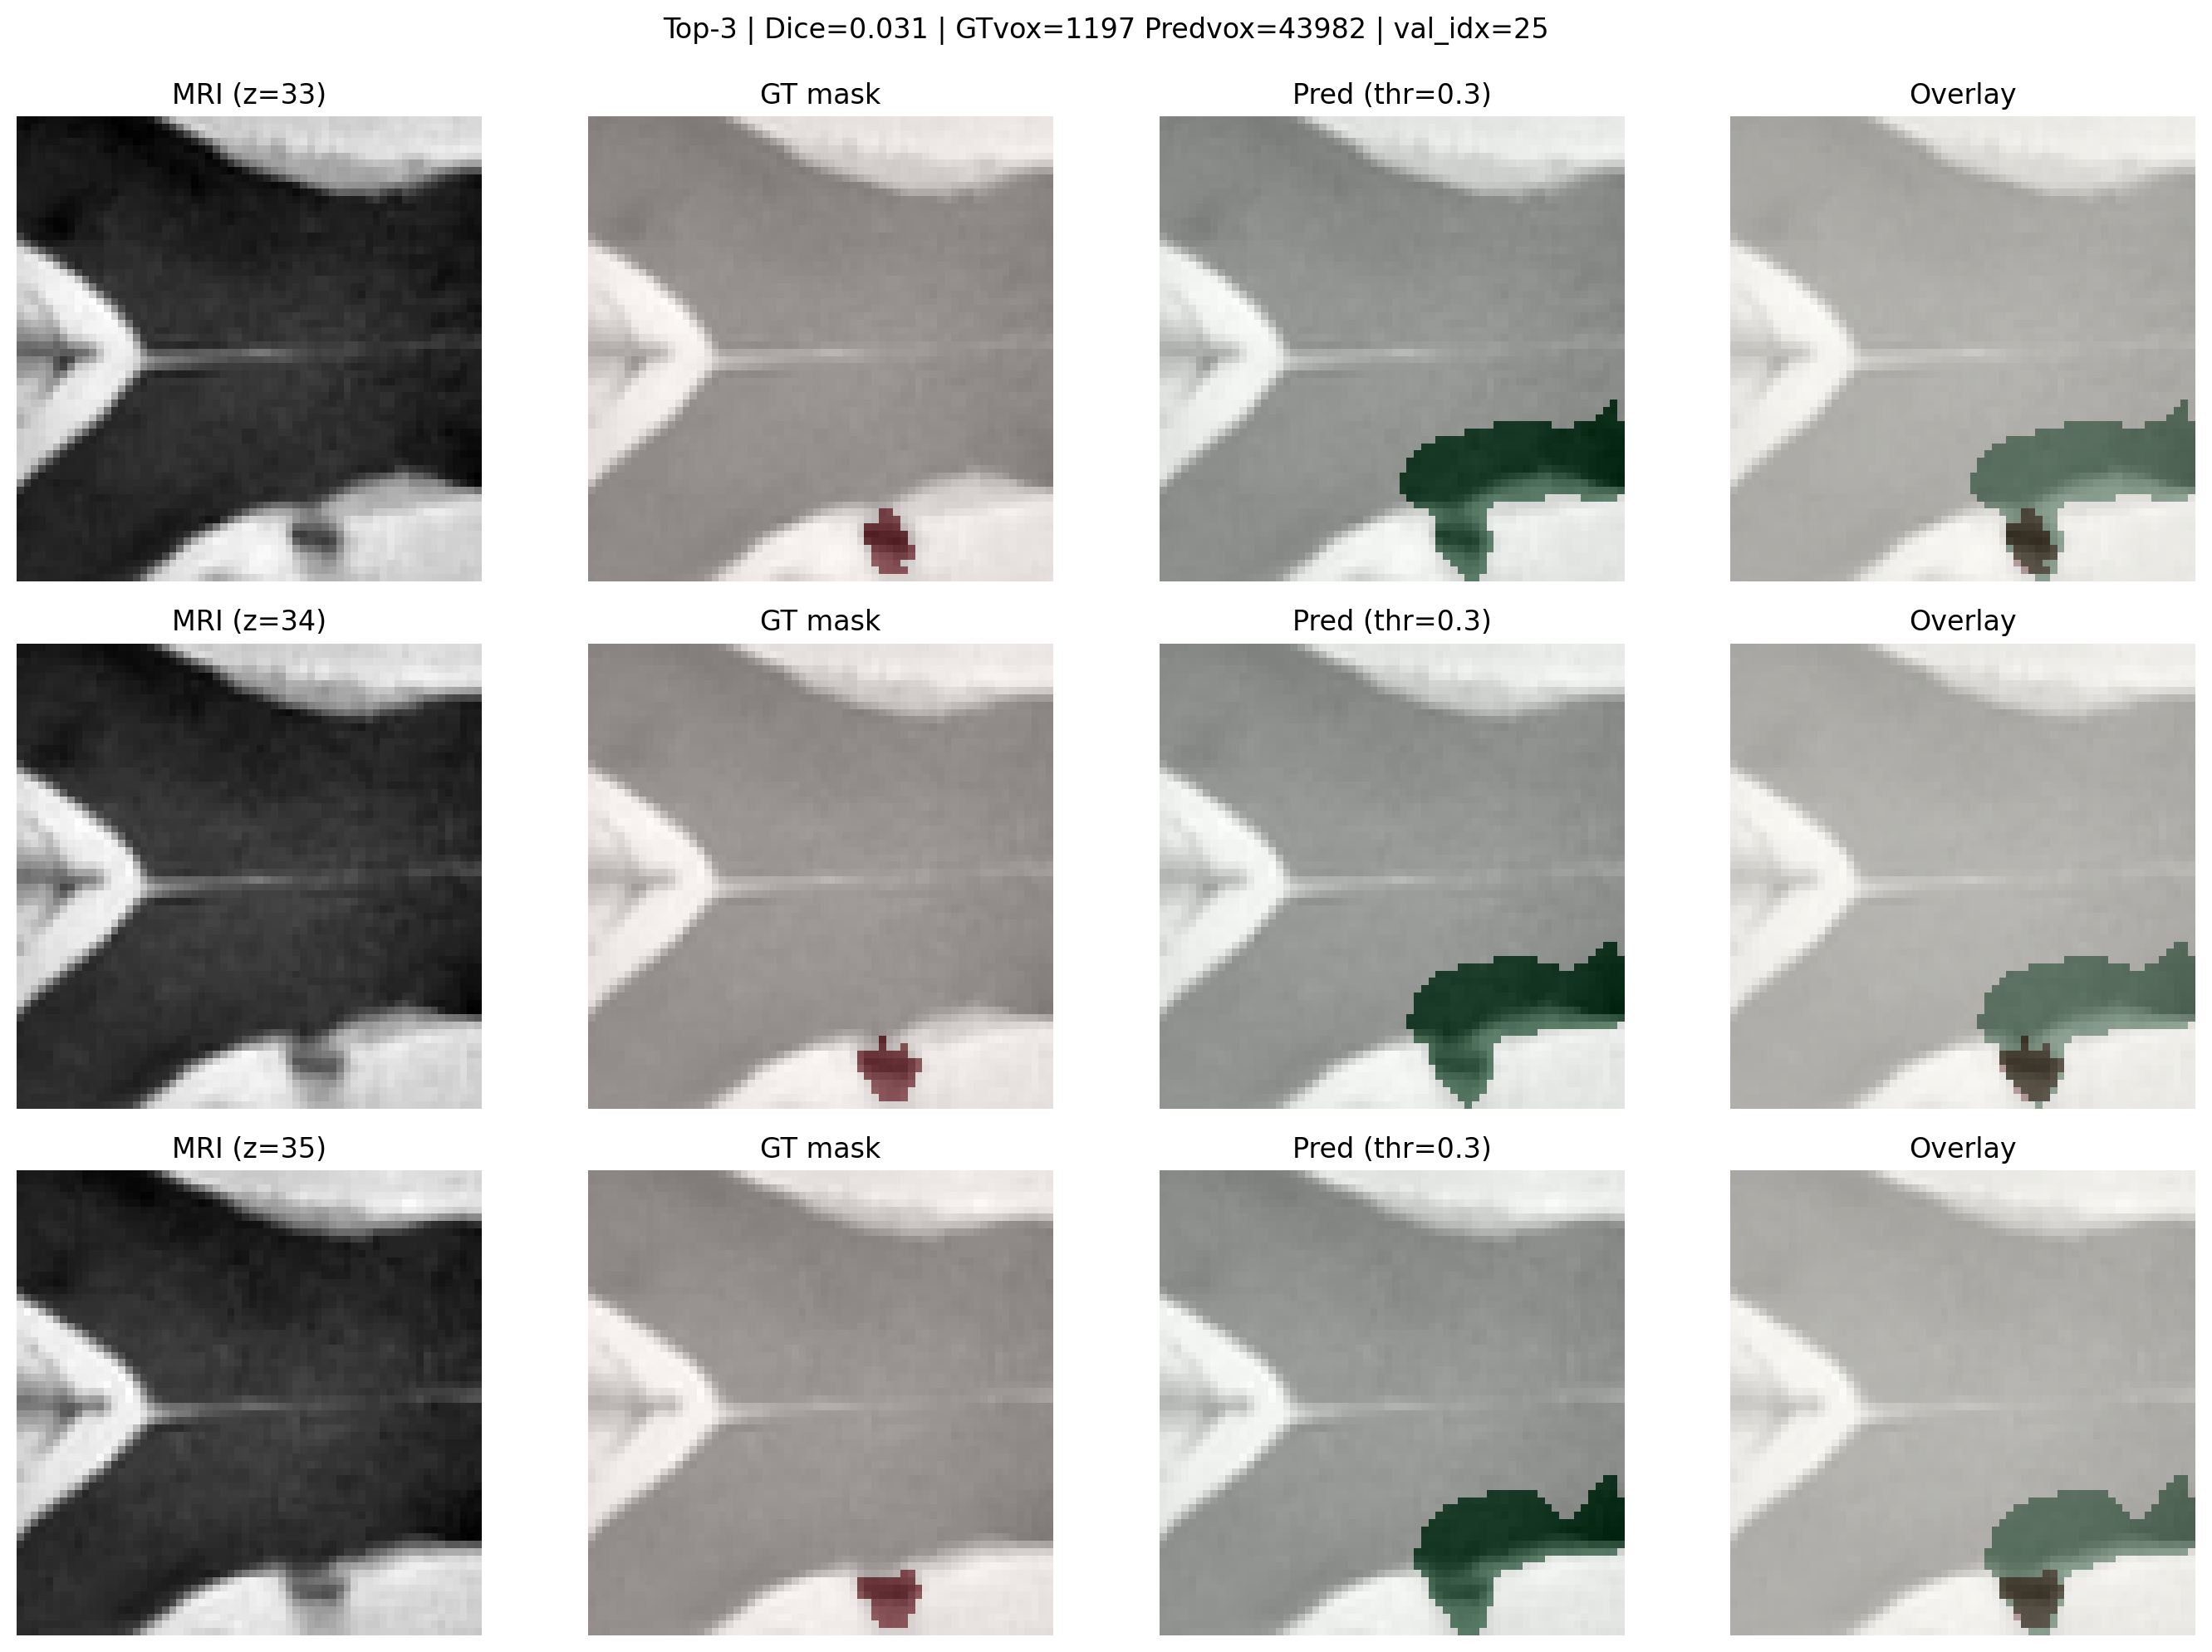

checkpoints/vis_topk/top3_dice0.171_gt3383_pr33825.png


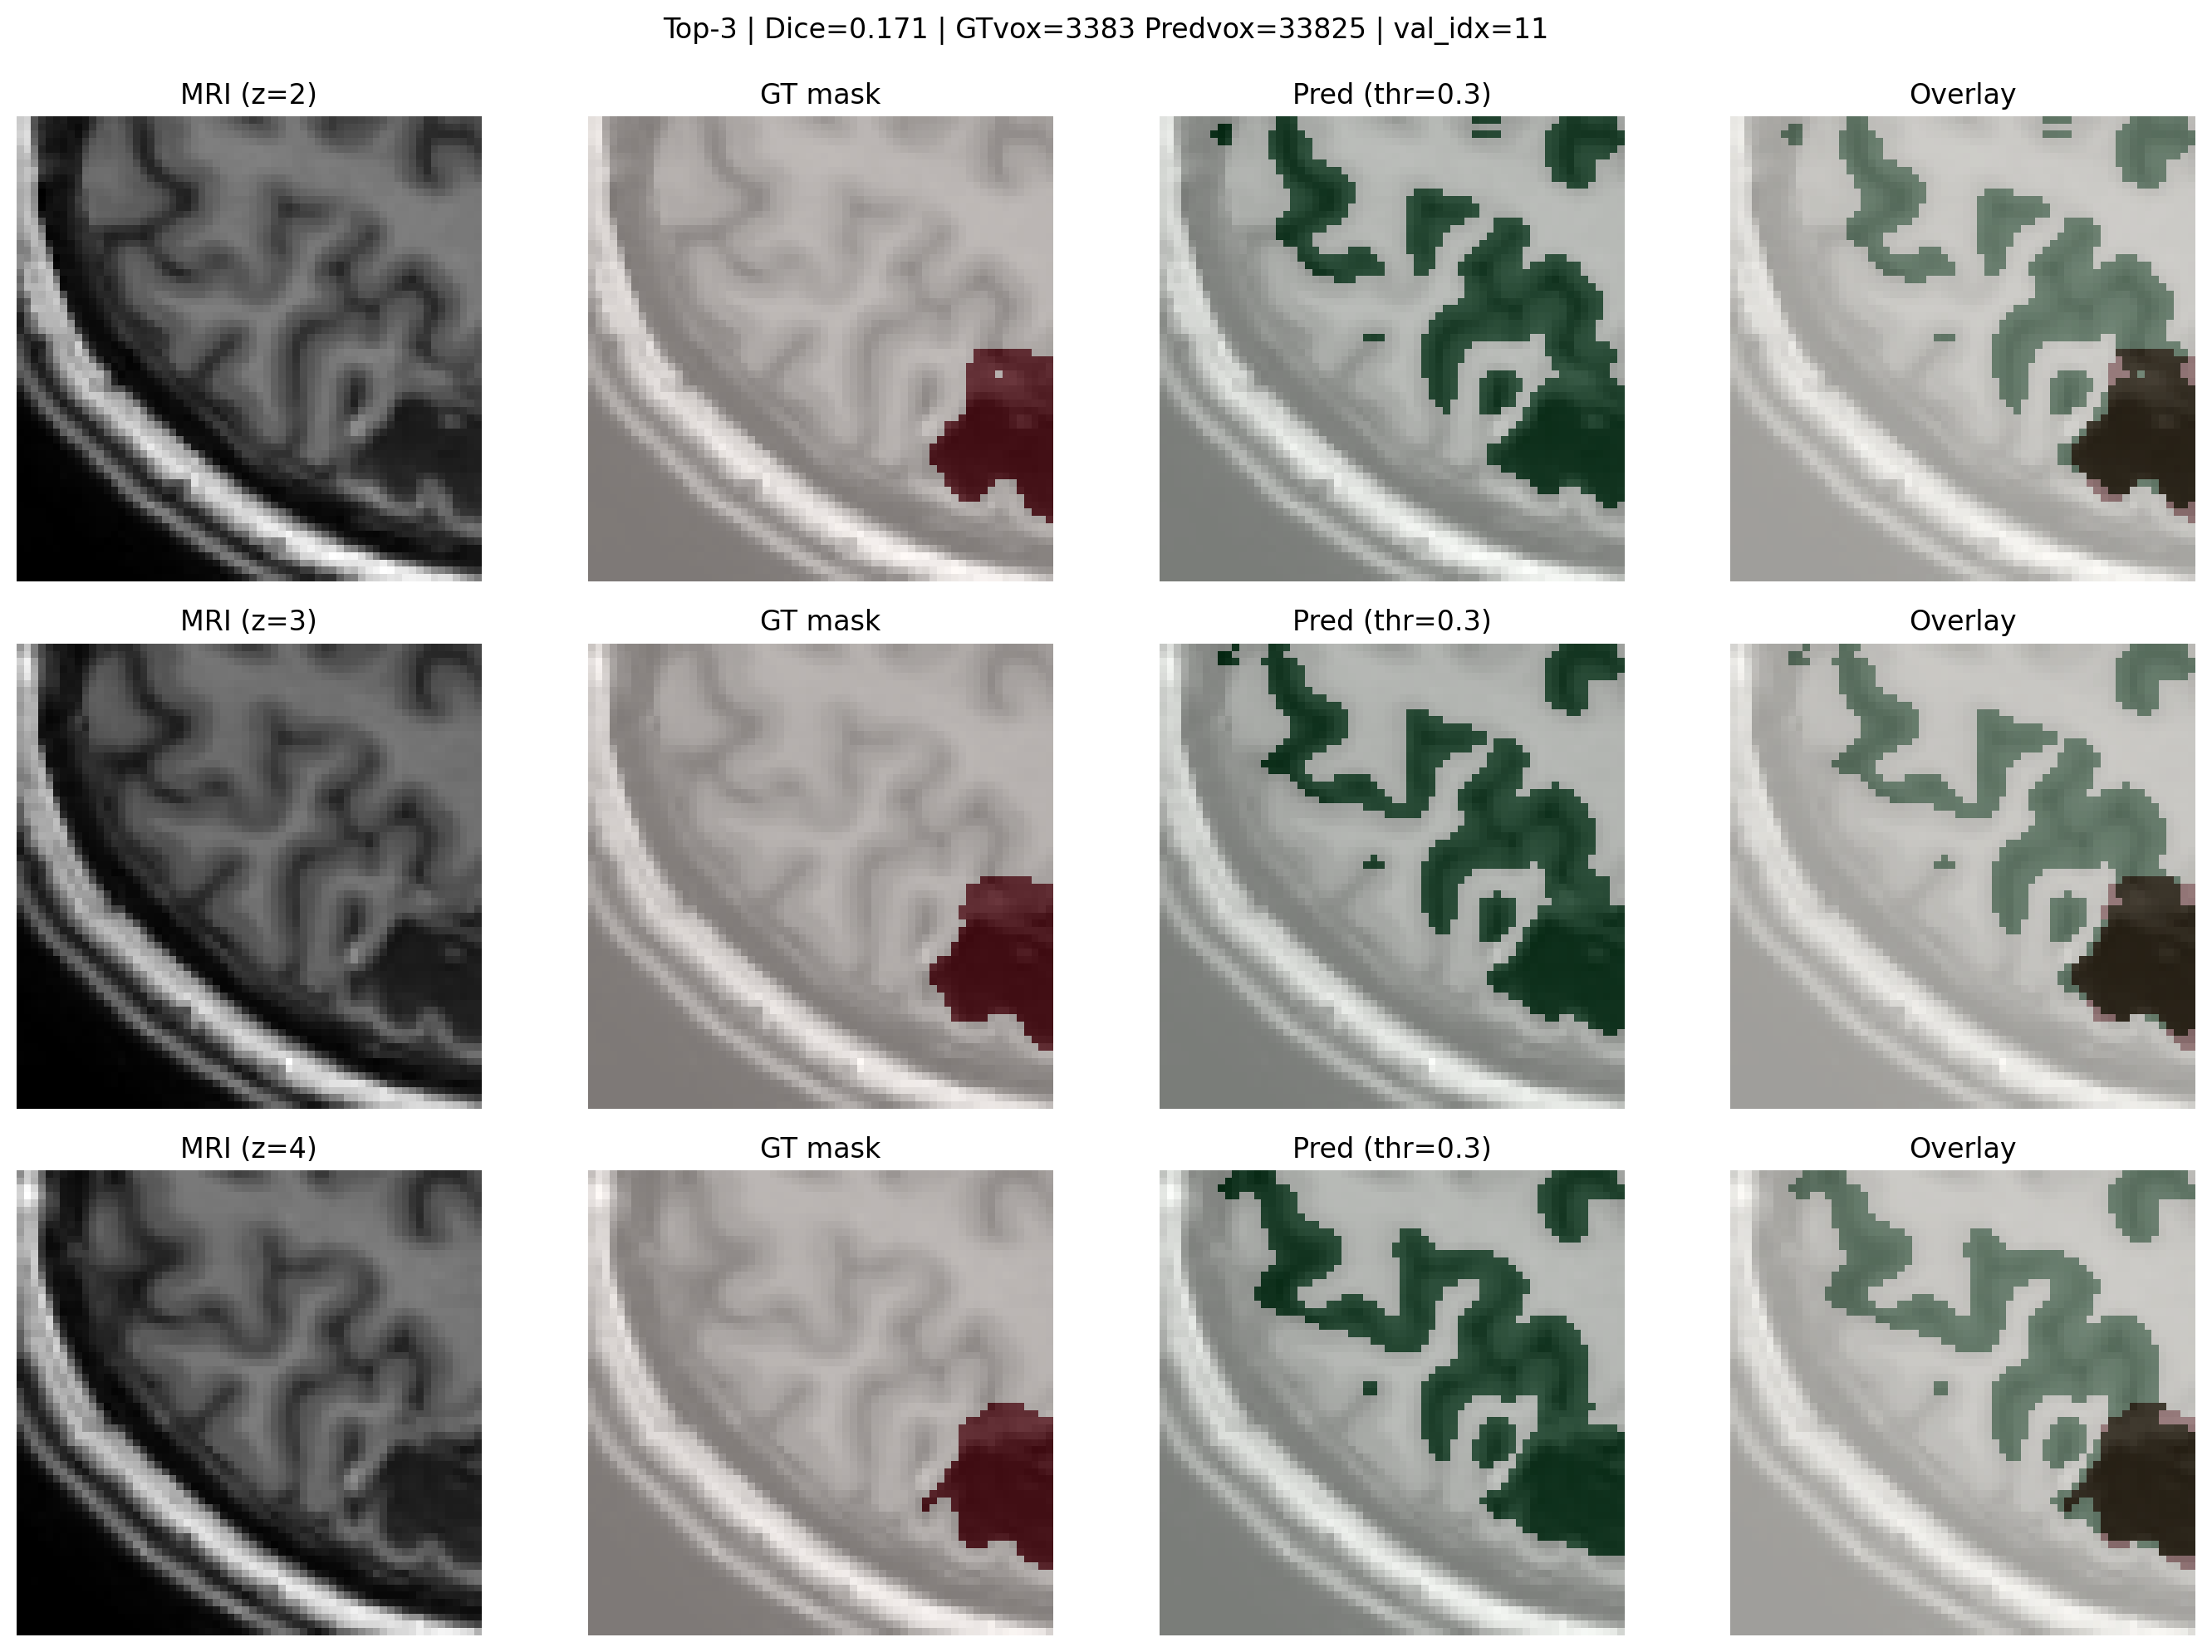

In [145]:
import glob
from IPython.display import Image, display

paths = sorted(glob.glob("checkpoints/vis_topk/*.png"))
for p in paths[:6]:
    print(p)
    display(Image(filename=p))

In [146]:
import os, glob, zipfile
from IPython.display import FileLink, display

img_dir = "checkpoints/vis_topk"
zip_path = "vis_topk_images.zip"   # 放在当前目录，方便下载

paths = sorted(glob.glob(os.path.join(img_dir, "*.png")))
print("found images:", len(paths))
print("\n".join(paths[:10]))

with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for p in paths:
        z.write(p, arcname=os.path.basename(p))

print("zip saved:", zip_path)
display(FileLink(zip_path))

found images: 12
checkpoints/vis_topk/top1_dice0.186_gt7052_pr54112.png
checkpoints/vis_topk/top1_dice0.767_gt83412_pr66711.png
checkpoints/vis_topk/top2_dice0.085_gt3414_pr54010.png
checkpoints/vis_topk/top2_dice0.171_gt5713_pr46870.png
checkpoints/vis_topk/top3_dice0.031_gt1197_pr43982.png
checkpoints/vis_topk/top3_dice0.171_gt3383_pr33825.png
checkpoints/vis_topk/top4_dice0.019_gt1905_pr36616.png
checkpoints/vis_topk/top4_dice0.029_gt647_pr37802.png
checkpoints/vis_topk/top5_dice0.011_gt248_pr44085.png
checkpoints/vis_topk/top5_dice0.018_gt525_pr57678.png
zip saved: vis_topk_images.zip


/Users/maguotong/isles_2022/vis_topk_images.zip

In [ ]:
import bidsio
bids_loader = bidsio.BIDSLoader(data_entities=[{'subject': '',
                                               'session': '',
                                               'suffix': 'T1w',
                                               'space': 'MNI152NLin2009aSym'}],
                                target_entities=[],
                                data_derivatives_names=['ATLAS'],
                                batch_size=4,
                                root_dir='data/test/')

In [ ]:
for dat, image_list in bids_loader.load_batch_for_prediction():
    print(f'Data shape: {dat.shape}')
    print(f'Example BIDS file: {image_list[0]}')
    break

In [ ]:
# Create great model.
#import numpy as np
#class some_model():
    #def __init__(self):
        '''
        Simple model to serve as an example.
        '''
        #return
    
    #def predict(self, data: np.ndarray) -> np.ndarray:
        '''
        Returns '1' for voxels whose value are greater than the image mean.
        Parameters
        ----------
        data : np.ndarray
            Data for which to make a prediction of the labels.
        Returns
        -------
        np.ndarray
            Model prediction for the input data.
    '''
        #data_mean = np.mean(data)
        #return np.array(data > data_mean, dtype=np.float32)
#your_model = some_model()

In [ ]:
help(bids_loader.write_image_like)

In [ ]:
example_output_dir = 'prediction_bids/'  # Directory where to write out predictions
for dat, image_list in bids_loader.load_batch_for_prediction():
    prediction = your_model.predict(dat)  # Make a prediction
    # Reduce to set of 3D images
    for i in range(prediction.shape[0]):  # Iterate through each sample in the batch
        pred_out = prediction[i,0,...]
        image_ref = image_list[i][0]
        print(f"Writing image for subject {image_ref.entities['subject']}")
        
        bids_loader.write_image_like(data_to_write=pred_out,
                                     image_to_imitate=image_ref,
                                     new_bids_root=example_output_dir,
                                     new_entities={'label': 'L',
                                                   'suffix': 'mask'})
    break

We see that we create a file for each subject present in our batch. Let's verify that the files were created.

In [ ]:
import os
for p, _, fnames in os.walk(example_output_dir):  # Walk through dir structure
    if(len(fnames) > 0):
        for f in fnames:
            print(os.path.join(p, f))  # Print full path of files that are found

In [ ]:
help(bidsio.BIDSLoader.write_dataset_description)

In [ ]:
bidsio.BIDSLoader.write_dataset_description(bids_root=example_output_dir,
                                            dataset_name='atlas2_prediction',
                                            author_names=['Hutton, A.'])

In [ ]:
import json, os
f = open(f'{example_output_dir}{os.sep}dataset_description.json')
dataset_description = json.load(f)
f.close()
print(dataset_description)

In [ ]:
import bids
prediction_bids = bids.BIDSLayout(root=example_output_dir, derivatives=example_output_dir)
print(prediction_bids.derivatives['atlas2_prediction'])